In [1]:
#import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Store the data into the df variable
df = pd.read_csv('../../data/ETH.csv')

In [3]:
#Set the date as the index for the data
df = df.set_index(pd.DatetimeIndex(df['begins_at'].values))
df['price'] = df[['high_price','low_price']].mean(axis=1)

Text(0, 0.5, 'Price USD ($)')

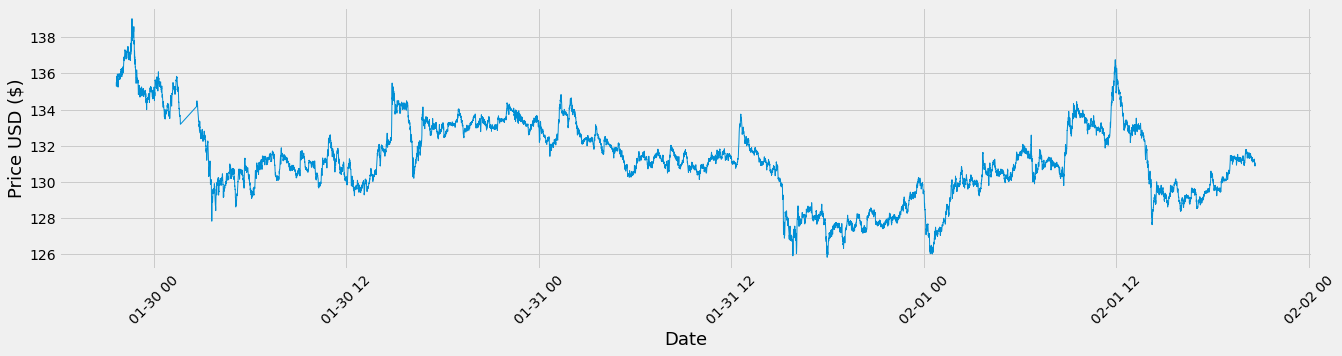

In [4]:
# Visually Show The Stock Price(s)
# Create the title
title = 'ETH Price'
#Get the stocks
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price', linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

plt.xticks(rotation=45) 
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
# plt.show()

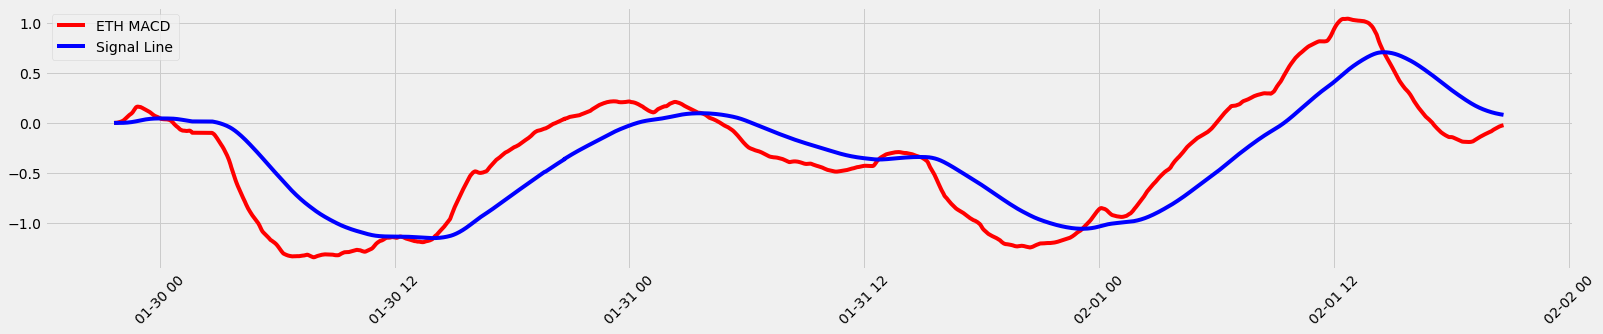

In [5]:
def createMacdAndSignalLines(macd_params, macd_multiplier):
    ShortEMA = df.price.ewm(span=macd_params[0]*macd_multiplier, adjust=False).mean() #AKA Fast moving average
    LongEMA = df.price.ewm(span=macd_params[1]*macd_multiplier, adjust=False).mean() #AKA Slow moving average
    Macd = ShortEMA - LongEMA
    signal = Macd.ewm(span=macd_params[2]*macd_multiplier, adjust=False).mean()
    return (Macd, signal)

macd_params = (12, 26, 9)
macd_multiplier = 175
macd, signal = createMacdAndSignalLines(macd_params, macd_multiplier)

plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.plot(df.index, macd, label='ETH MACD', color = 'red')
plt.plot(df.index, signal, label='Signal Line', color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
# profit, trans = mac_daddy_tester(MACD, signal, df)
# print((i, profit))
# t.insert((i, profit))

In [6]:
df['MACD'] = macd
df['Signal Line'] = signal

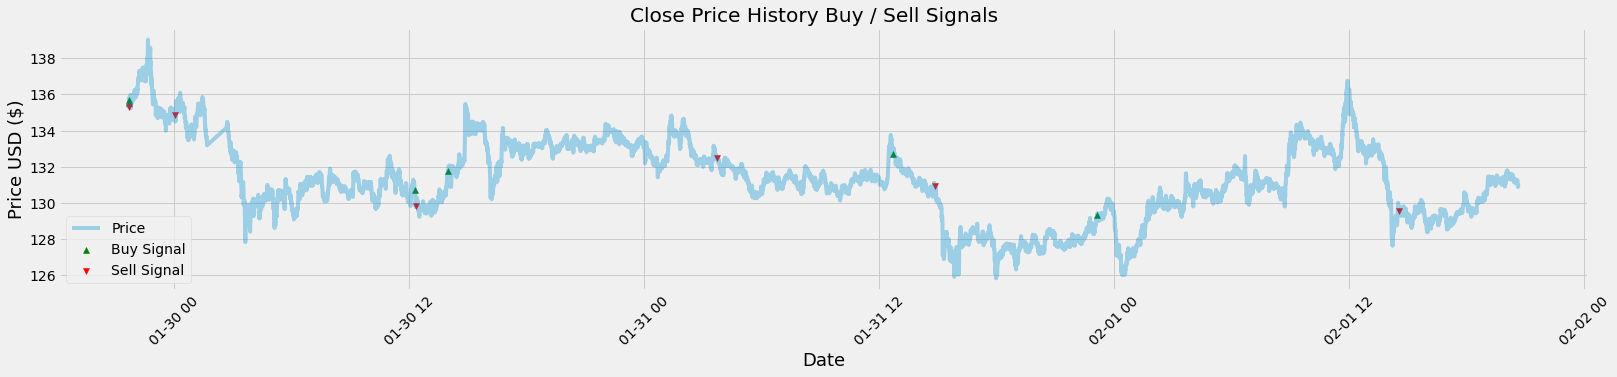

2021-01-29T21:40:30Z Bought at 135.805  selling at 135.215 for profit: -2.5900000000000034
2021-01-30T00:02:00Z Bought at 135.625  selling at 134.715 for profit: -2.9099999999999966
2021-01-30T12:19:15Z Bought at 130.655  selling at 130.12 for profit: -2.5349999999999966
2021-01-31T03:42:15Z Bought at 131.785  selling at 132.885 for profit: -0.9000000000000057
2021-01-31T14:51:30Z Bought at 132.73  selling at 130.965 for profit: -3.7649999999999864
2021-02-01T14:32:45Z Bought at 129.72  selling at 129.625 for profit: -2.094999999999999
Profit -8.794999999999987
trans:  6


In [7]:
# Function to test the crossover driven profits of the macd and signal lines
def mac_daddy_tester(macd, signal, df, quiet=False):
    bought = False
    sumwin = 0
    transactions = []
    for i in range(1, len(signal)):
        if ( (macd.iat[i] > signal.iat[i]) and (macd.iat[i-1] <= signal.iat[i-1]) and bought == False):
            # print("Crossed above, time to buy", i)
            bought = df.iat[i,1]
        if ( (macd.iat[i] < signal.iat[i]) and (macd.iat[i-1] >= signal.iat[i-1]) and bought):
            # print("Crossed below, time to sell", i)
            if not quiet:
              print(df.iat[i,0], "Bought at", bought, " selling at", df.iat[i,1], "for profit:", df.iat[i,1] - bought - 2)
            transactions.append(df.iat[i,1] - bought)
            sumwin = sumwin + df.iat[i,1] - bought - 1
            bought = False 
    return(sumwin, transactions)


#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1
  for i in range(0,len(signal)):
    #if MACD > signal line  then buy else sell
      if signal['MACD'][i] > signal['Signal Line'][i]:
        if flag != 1:
          sigPriceBuy.append(signal['price'][i])
          sigPriceSell.append(np.nan)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      elif signal['MACD'][i] < signal['Signal Line'][i]: 
        if flag != 0:
          sigPriceSell.append(signal['price'][i])
          sigPriceBuy.append(np.nan)
          flag = 0
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)


#Create buy and sell columns
x = buy_sell(df)
df['Buy_Signal_Price'] = x[0]
df['Sell_Signal_Price'] = x[1]

# Visually Show The Stock buy and sell signals
# Create the title 
title = 'Close Price History Buy / Sell Signals   '
#Get the stocks
my_stocks = df
  
#Create and plot the graph
plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.scatter(my_stocks.index, my_stocks['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
plt.scatter(my_stocks.index, my_stocks['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
plt.plot( my_stocks['price'],  label='Price', alpha = 0.35)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.xticks(rotation=45)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.legend( loc='lower left')
plt.show()

r = mac_daddy_tester(macd, signal, df)
print("Profit", r[0])
print("trans: ", len(r[1]))
# print(r[1])

In [8]:
results = []
for period_length in np.arange(5, 700, 5):
    macd_params = (12, 26, 9)
    macd_multiplier = period_length #was 111
    macd, signal = createMacdAndSignalLines(macd_params, macd_multiplier)
    r = mac_daddy_tester(macd, signal, df, quiet=True)
    results.append((period_length, r[0], len(r[1])))
    # print(period_length, "Profit", r[0], "transactions: ", len(r[1]))
sorted(results, key = lambda x: -x[1])

[(110, -0.539999999999992, 5),
 (100, -1.7700000000000387, 5),
 (105, -2.194999999999993, 5),
 (115, -3.0050000000000097, 6),
 (95, -3.4799999999999898, 6),
 (685, -3.4950000000000045, 2),
 (690, -3.4950000000000045, 2),
 (695, -3.4950000000000045, 2),
 (665, -3.780000000000001, 2),
 (670, -3.780000000000001, 2),
 (655, -4.094999999999999, 2),
 (660, -4.094999999999999, 2),
 (675, -4.3700000000000045, 2),
 (680, -4.3700000000000045, 2),
 (645, -4.390000000000015, 2),
 (650, -4.390000000000015, 2),
 (120, -4.430000000000007, 6),
 (640, -4.77000000000001, 3),
 (125, -6.074999999999989, 6),
 (190, -6.075000000000017, 5),
 (130, -6.090000000000018, 6),
 (135, -6.3300000000000125, 6),
 (480, -7.0049999999999955, 3),
 (485, -7.085000000000008, 3),
 (565, -7.094999999999999, 3),
 (520, -7.115000000000009, 3),
 (635, -7.164999999999992, 3),
 (505, -7.190000000000026, 3),
 (490, -7.27000000000001, 3),
 (425, -7.280000000000001, 3),
 (630, -7.314999999999998, 3),
 (180, -7.335000000000036, 5),
 